<a href="https://colab.research.google.com/github/TacticalNuclearRaccoon/Artificial-Neural-Networks/blob/main/Neural_Network_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the gpu version of Tensorflow into the environment with pip install.

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 458.3 MB 12 kB/s 


In [2]:
#Displaying which version of tensorflow was installed
import tensorflow as tf
print(tf.__version__)

2.6.0


#**Basic regression: Predict fuel efficiency**

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [4]:
# Use seaborn for pairplot
!pip install -q seaborn

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read (with less numbers after the deciman point).
np.set_printoptions(precision=3, suppress=True)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


In [7]:
#Download the data from the University Of California rvine (UCI) repository
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

##**Inspecting and Cleaning the data**

In [8]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
#Dropping the empty values
dataset = dataset.dropna()

In [11]:
#Converting the "Origin" column into one-hot encoding because it is really categorical:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [12]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## **Split the data into train and test**

In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## **Inspect the data**
We are focusing on the MPG, Cylinders, Displacement and Weight attributes. We have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other.

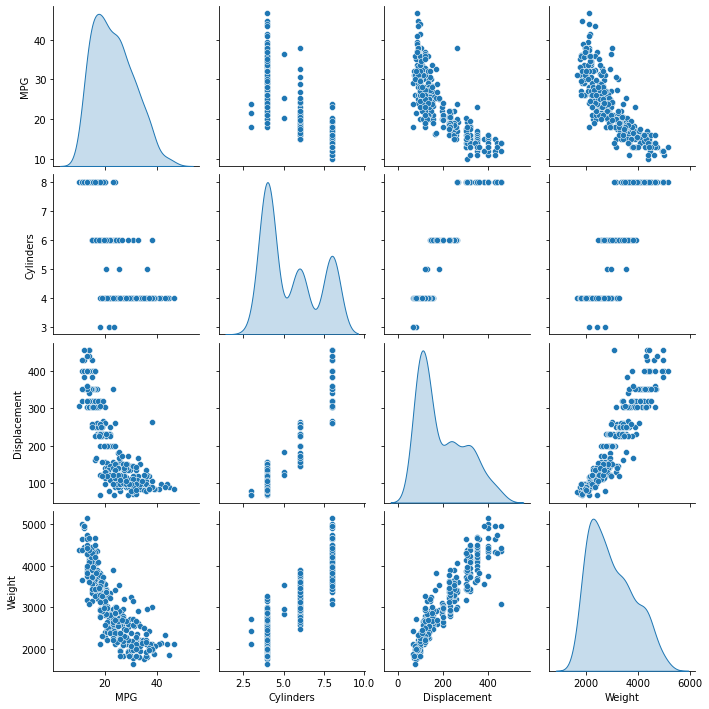

In [14]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

## Summary statistics

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


##Split features from labels
Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

##Normalization
In the table of statistics it's easy to see how different the ranges of each feature are.

In [17]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

##The Normalization layer
The preprocessing.Normalization layer is a clean and simple way to build that preprocessing into your model.


In [18]:
# Step1: Creating the layer
normalizer = preprocessing.Normalization(axis=-1)

#Step2: Adapting the layer to the data. This calculates the mean and variance, and stores them in the layer.
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [19]:
# When the layer is called it returns the input data, with each feature independently normalized:

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


#**Linear regression**
Before building a DNN model, start with a linear regression.

## One Variable
Start with a single-variable linear regression, to predict MPG from Horsepower.

Training a model with tf.keras typically starts by defining the model architecture.

In this case use a keras.Sequential model. This model represents a sequence of steps. In this case there are two steps:

##Normalize the input horsepower

Apply a linear transformation to produce 1 output using layers.Dense.
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.


In [20]:
#First create the horsepower Normalization layer:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

# Build seqential model:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict MPG from Horsepower.


In [21]:
#Run the untrained model on the first 10 horse-power values. The output won't be good but it will have the expected shape, (10,1):
horsepower_model.predict(horsepower[:10])

array([[ 1.279],
       [ 0.723],
       [-2.361],
       [ 1.793],
       [ 1.622],
       [ 0.637],
       [ 1.922],
       [ 1.622],
       [ 0.423],
       [ 0.723]], dtype=float32)

## Loss function and the Optimizer

In [22]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Executing the training with model.fit()

In [23]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.92 s, sys: 166 ms, total: 3.09 s
Wall time: 2.71 s


In [24]:
#Visualize the model's training progress using the stats stored in the history (hist) object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804329,4.164343,95
96,3.807924,4.176912,96
97,3.802976,4.188519,97
98,3.802847,4.191860,98
99,3.807281,4.202304,99


In [25]:
def plot_loss(history):
  '''This function plots the history of the trainig process'''
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

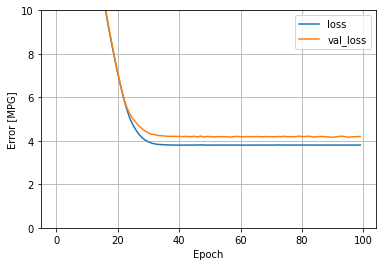

In [26]:
plot_loss(history)

In [27]:
#Collect the results on the test set, for later:

test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
#Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [28]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

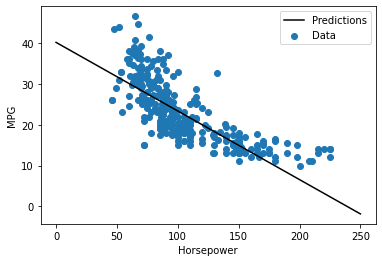

In [29]:
plot_horsepower(x,y)

## Multiple inputs
We can use a similar setup to make predictions based on multiple inputs. This model still does the same *y=mx+b* except that *m* is a matrix and *b* is a vector.

This time use the Normalization layer that was adapted to the whole dataset.

In [30]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [31]:
#When you call this model on a batch of inputs, it produces units=1 outputs for each example.

linear_model.predict(train_features[:10])

array([[ 2.064],
       [ 1.296],
       [-1.397],
       [ 1.057],
       [ 1.187],
       [ 0.   ],
       [ 1.291],
       [-0.587],
       [ 0.633],
       [ 1.957]], dtype=float32)

In [32]:
#When you call the model it's weight matrices will be built

linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.754],
       [-0.697],
       [-0.412],
       [ 0.273],
       [ 0.112],
       [-0.479],
       [-0.247],
       [ 0.522],
       [ 0.771]], dtype=float32)>

In [34]:
#Use the same compile and fit calls as for the single input horsepower model:

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.91 s, sys: 189 ms, total: 3.09 s
Wall time: 2.7 s


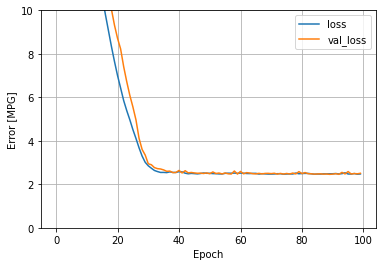

In [36]:
plot_loss(history)

As seen above, using all the inputs achieves a lower training and validation error than the horsepower model

In [38]:
#Collect the results on the test set:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# *A DNN regression*
The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

*   The normalization layer
*   Two hidden, nonlinear, Dense layers using the relu nonlinearity.
*   A linear single-output layer.

Both will use the same training procedure so the compile method is included in the build_and_compile_model function below.

In [39]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

##One variable

In [40]:
#Start with a DNN model for a single input: "Horsepower"

dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

#This model has quite a few more trainable parameters than the linear models.

dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
#Train the model:

%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.23 s, sys: 241 ms, total: 3.47 s
Wall time: 3.01 s


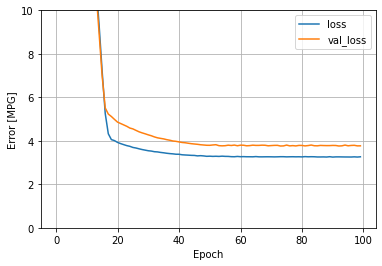

In [42]:
plot_loss(history)

This model does maybe slightly better than the linear model

In [43]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

If we plot the predictions as a function of Horsepower, we can see how this model takes advantage of the nonlinearity provided by the hidden layers

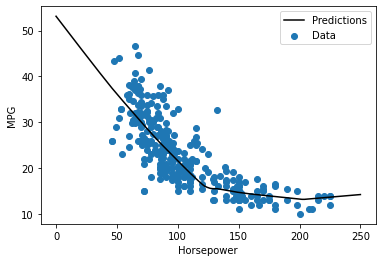

In [44]:
plot_horsepower(x, y)

In [45]:
#Collect the results on the test set:

test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Full model

In [46]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [47]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.37 s, sys: 239 ms, total: 3.61 s
Wall time: 3.11 s


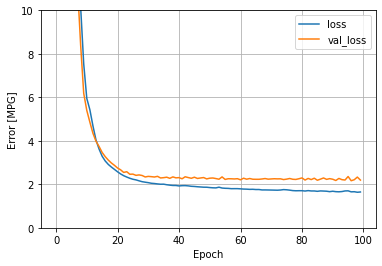

In [48]:
plot_loss(history)

In [49]:
# Collecting the results on the test set
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [52]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.652807
linear_model,2.533583
dnn_horsepower_model,2.951187
dnn_model,1.805694


These results match the validation error seen during training.


##Make predictions

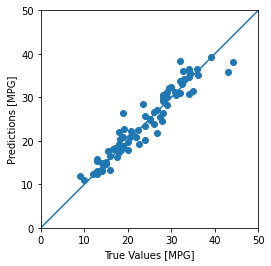

In [53]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

###The error distribution:

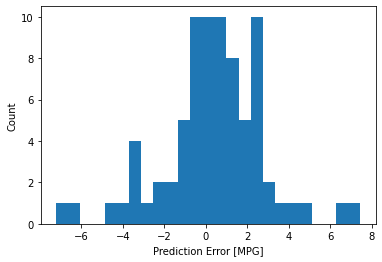

In [54]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [55]:
# Saving the model for later use
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [56]:
# Reloading the model (gives the same results)
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.652807
linear_model,2.533583
dnn_horsepower_model,2.951187
dnn_model,1.805694
reloaded,1.805694


## **Conclusion**
This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

  * Mean Squared Error (MSE) and Mean Absolute Error (MAE) are common loss functions used for regression problems. 

  * Mean Absolute Error is less sensitive to outliers. 

  * Different loss functions are used for classification problems.

  * Similarly, evaluation metrics used for regression differ from classification.

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
